<a href="https://colab.research.google.com/github/Denisganga/ImageClassificationModel/blob/main/image_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt #for plotting
import numpy as np # for transformation

import torch #pytorch package
import torchvision#load datasets
import torchvision.transforms as transforms #transform data
import torch.nn as nn #basic building block for neural networks
import torch.nn.functional as F #import convolution functions like Relu
import torch.optim as optim #optimizer

In [2]:
#python image library of range [0,1]
#transform them to tensors of normalized range[-1,1]

transform = transforms.Compose( # composing several transforms together
    [transforms.ToTensor(), # to tensor object
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5

#set batch_size
batch_size = 4

#set number of workers
num_workers= 2


#load train data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader =torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True,num_workers=num_workers)

#load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)

#put 10 classes into a set
classes =('plane','car','bird','cat',
          'deer','dog','frog','horse','ship','truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 44166748.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


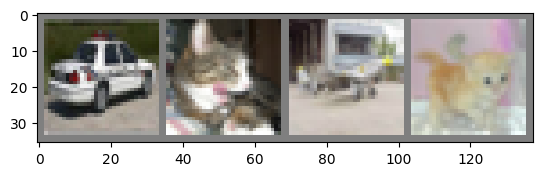

Class labels for each image in the batch:
car cat plane cat


In [3]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    ''' Function to show image '''
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()  # Convert to numpy objects
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of random training images with a for loop
for images, labels in trainloader:
    # Call the function on our images and display them
    imshow(torchvision.utils.make_grid(images))

    # Print the class labels for each image in the batch
    print("Class labels for each image in the batch:")
    print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

    # Break the loop to display only one batch of images (remove this line if you want to see multiple batches)
    break



In [5]:
#Now its time to build our network

class Net(nn.Module):
  ''' Models a simple Convolutional Neural Network'''
  def __init__(self):
    ''' initialize the network '''
    super(Net, self).__init__()
    #3 input image channel, 6 output channels,
    #5*5 square convolution kernel
    self.conv1=nn.Conv2d(3, 6, 5)

    #Max pooling over a (2, 2) window
    self.pool=nn.MaxPool2d(2, 2)
    self.conv2=nn.Conv2d(6, 16, 5)
    self.fc1=nn.Linear(16 * 5 * 5, 120 )#5*5 from image dimension
    self.fc2=nn.Linear(120, 84)
    self.fc3=nn.Linear(84,10)

  def forward(self, x):
    ''' the forward propagation algorithm '''
    x= self.pool(F.relu(self.conv1(x)))
    x= self.pool(F.relu(self.conv2(x)))
    x= x.view(-1, 16 * 5* 5)
    x= F.relu(self.fc1(x))
    x= F.relu(self.fc2(x))
    x= self.fc3(x)
    return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [6]:
#define a loss function optmizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
#train the network
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):#loop over the dataset ,multiple times

  running_loss =0.0
  for i,data in enumerate(trainloader, 0):
    #get the inputs; data is a list of [inputs,labels]
    inputs, labels =data

    #zero the parameter gradients
    optimizer.zero_grad()

    #forward+backword+optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #print statistics
    running_loss +=loss.item()
    if i % 2000 ==1999:
      print('[%d, %5d] loss: %.3f' %
            (epoch +1, i+1, running_loss /2000))
      running_loss = 0.0

end.record()

torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

[1,  2000] loss: 2.216
[1,  4000] loss: 1.950
[1,  6000] loss: 1.726
[1,  8000] loss: 1.583
[1, 10000] loss: 1.549
[1, 12000] loss: 1.475
[2,  2000] loss: 1.400
[2,  4000] loss: 1.394
[2,  6000] loss: 1.345
[2,  8000] loss: 1.356
[2, 10000] loss: 1.316
[2, 12000] loss: 1.284
Finished Training
115466.796875
